## **Adversarial Perturbations Fool Deepfake Detectors**
FIT3183 2020 S2 Assignment
<br/>By Team Dark.HAIYA
<br/>Team members:
- Kee Pei Jiin
- Chin Wen Yuan

This colab demonstrates our attempts to fool an XceptionNet deepfake detector. It is created based on this [research paper](https://arxiv.org/pdf/2003.10596.pdf)[1] and its corresponding [GitHub](https://github.com/ApGa/adversarial_deepfakes).

You can watch our demo video at:

## **Colab Setup**
Please change runtime type to GPU.

### **Import Libraries**

In [ ]:
import gdown
import sys 
import os
import glob
import imghdr
import numpy as np
from math import ceil
from PIL import Image
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
from keras.models import load_model
from keras.losses import categorical_crossentropy
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

### **Helper Functions**
Some functions that help to process images, evaluate model performance and display outputs.

In [ ]:
# for data/image preparation
classes = ["real", "fake"] # label 0: real, label 1: fake
num_classes = 2

def load_images_and_prepare_labels(image_folder_path):
    images_paths, labels = [], []
    for class_name in os.listdir(image_folder_path):
      class_root = os.path.join(image_folder_path, class_name)
      class_id = classes.index(class_name)
      for path in os.listdir(class_root):
          path = os.path.join(class_root, path)
          if imghdr.what(path) is None:
              # this is not an image file
              continue
          images_paths.append(path)
          labels.append(class_id)
    # convert ot numpy array
    images_paths = np.array(images_paths)
    return images_paths, labels

In [ ]:
# for model classification
def load_image_as_np_arr(img_path): # load img as np array
    img = image.load_img(img_path, target_size=(128, 128))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def load_image_as_tensor(img_path): # load img as tensor
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (128, 128))
    img = preprocess_input(img)
    img = img[None, ...]
    return img

def classify(model, x): # x is a np array, use model to predict the label of x
    pred = model.predict(x)[0]
    pred_label = np.argmax(pred)
    return pred_label

In [ ]:
# for image visualization
def denormalize_img(x):
    # x is the image represented in numpy array
    x = (x+1)*127.5
    x /= 255
    # x = np.clip(x, 0, 255)
    return x

# visualize normal & perturbed image side by side
# also display their prediction labels
def display_image_pair(x, adv_x, actual_label, pred_label):
    # x and adv_x are numpy arrays
    x = x.squeeze()
    x = denormalize_img(x)
    adv_x = adv_x.squeeze()
    adv_x = denormalize_img(adv_x)

    # both x and adv_x are numpy array
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(x); ax[0].axis("off")
    ax[0].set_title("Original image", fontsize=15)
    ax[0].text(0.5,-0.13, "Actual class: {}".format(classes[actual_label]), 
                size=12, ha="center", transform=ax[0].transAxes)
    
    ax[1].imshow(adv_x); ax[1].axis("off")
    ax[1].set_title("Perturbed image", fontsize=15)
    ax[1].text(1.8,-0.13, "Predicted class: {}".format(classes[pred_label]), 
                size=12, ha="center", transform=ax[0].transAxes)
    
    ax[2].axis("off")
    
    plt.show()

In [ ]:
# for model performance evaluation
def evaluate_model_performance(img_paths, labels, attack_fn=None, display_num=3):
    # positive: fake, negative: real
    true_positive = 0   # predict fake as fake
    false_positive = 0  # predict fake as real
    true_negative = 0   # predict real as real
    false_negative = 0  # predict real as fake

    display_i = 0  # number of display sample

    for i in range(len(img_paths)):
      img_path = img_paths[i]
      actual_label = labels[i]

      # load an input image
      x = load_image_as_np_arr(img_path)

      # predict the label of image
      if attack_fn is None:
          pred_label = classify(final_model, x)
      else:
          if attack_fn == "fgsm":
            adv_x = fgsm(img_path, actual_label)
          elif attack_fn == "fgvm":
            adv_x = fgvm(img_path, actual_label)
          elif attack_fn == "simple one pixel":
            adv_x = simple_one_pixel_attack(x)
          elif attack_fn == "one pixel with differetial evolution":
            adv_x = one_pixel_attack(x, actual_label, final_model, maxiter=20)
          else:
            raise Exception("Attack method not supported")
            
          pred_label = classify(final_model, adv_x)
          # selectively display a few fake images result
          display_imgs = ["111.jpg", "251.jpg", "698.jpg"]
          if actual_label == 1 and os.path.basename(img_path) in display_imgs:
            display_image_pair(x, adv_x, actual_label, pred_label)

      # compare prediction with ground truth
      # label 0: real, label 1: fake
      if actual_label == 0:
        if pred_label == 0:
          true_negative += 1
        else:
          false_negative += 1
      else:
        if pred_label == 1:
          true_positive += 1
        else:
          false_positive += 1

    return true_positive, false_positive, true_negative, false_negative

## **Datasets**
Initially, we attempted to generate our own deepfake images following the [Pytorch DCGAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). Our [Kaggle notebook](https://www.kaggle.com/peijiin/synthesize-face-images-with-dcgan) generates 500 fake images with the dimension of 128*128 using the CelebA dataset.

However, we found the quality of our deepfakes is too low, and the quality does not improve even after we increase the epoch number. Hence, we decided to use a set of 1000 DCGAN fake images generated by [2]. Interestingly, this research work is also the main reference paper of Team Light.DP. The researchers had also trained a DCGAN to generate fake images using the CelebA dataset. When compared to our fake images, the researchers' fake images generally have higher quality, as shown below.



As such, the images we use in this assignment are as follows:
- Real images: 1000 cropped celebA images, with size of 128*128. 

- Fake images: 1000 DGCAN fake images generated by [2], with size 128*128.

More of our dataset preparation can be found in [this Colab](https://colab.research.google.com/drive/1cqEkS3ZE2gcMsxBqHBv1epfdkgzfY695?usp=sharing).

In [ ]:
# download testing images (containing cropped CelebA images and the researchers' DCGAN images)
!gdown https://drive.google.com/uc?id=1HrkXC4fjVojzC15d-i1lNtad8dnzo4oE

!unzip -q /content/testing_images.zip
!rm -r /content/testing_images.zip

!mv /content/content/testing_images /content/
!rm -r /content/content

Downloading...
From: https://drive.google.com/uc?id=1HrkXC4fjVojzC15d-i1lNtad8dnzo4oE
To: /content/testing_images.zip
100% 1.50M/1.50M [00:00<00:00, 101MB/s]


In [ ]:
# load the real and fake images in testing datasets
all_images, labels = load_images_and_prepare_labels("/content/testing_images")

In [ ]:
# index 0 - 199 are fake images, select 64 of them
# index 200 - 399 are real images, select 64 of them
fake_images = all_images[:64]
real_images = all_images[200:264]
print(len(fake_images), len(real_images))

64 64


In [ ]:
# download the fake images that we generated
!gdown https://drive.google.com/uc?id=1l_rBcS0gIWEnSQQN23a-DQciSsk4JR6i

!unzip -q /content/dark_haiya_deepfake.zip
!rm -r /content/dark_haiya_deepfake.zip

Downloading...
From: https://drive.google.com/uc?id=1l_rBcS0gIWEnSQQN23a-DQciSsk4JR6i
To: /content/dark_haiya_deepfake.zip
100% 231k/231k [00:00<00:00, 79.9MB/s]


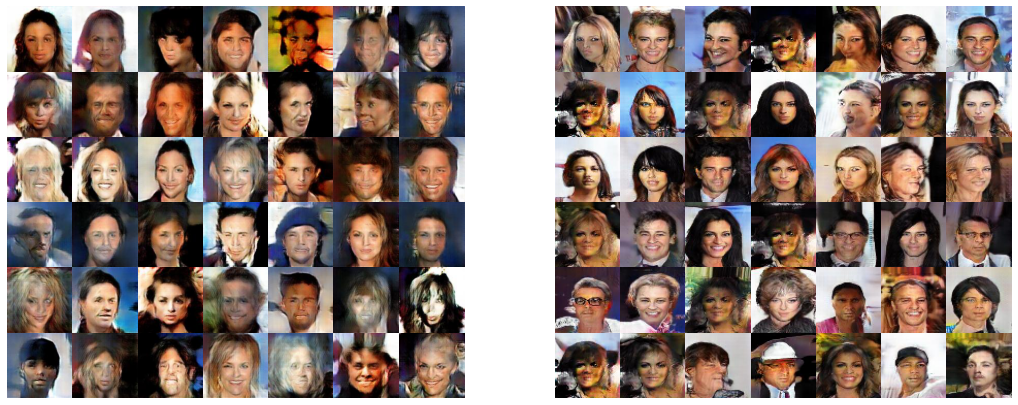

In [ ]:
# display our own deepfakes and researchers' deepfakes side by side
our_deepfakes = glob.glob("/content/fake/*")
our_deepfakes = our_deepfakes[:64]

fig = plt.figure(figsize=(18, 18))
our_deepfake_grid = ImageGrid(fig, 121,
                          nrows_ncols=(6, 7),
                          axes_pad=0)

fake_img_grid = ImageGrid(fig, 122,  # similar to subplot(111)
                          nrows_ncols=(6, 7),  # creates 2x2 grid of axes
                          axes_pad=0,  # pad between axes in inch.
                          )

for ax, img_path in zip(our_deepfake_grid, our_deepfakes):
    img = Image.open(img_path)
    # Iterating over the grid returns the Axes.
    ax.imshow(img)
    ax.axis("off")

for ax, img_path in zip(fake_img_grid, fake_images):
    img = image.load_img(img_path, target_size=(64, 64))
    img = image.img_to_array(img)
    img /= 255
    # Iterating over the grid returns the Axes.
    ax.imshow(img)
    ax.axis("off")

plt.show()

Left: Images generated by Team Dark.HAIYA                              

Right: Images generated by [2]

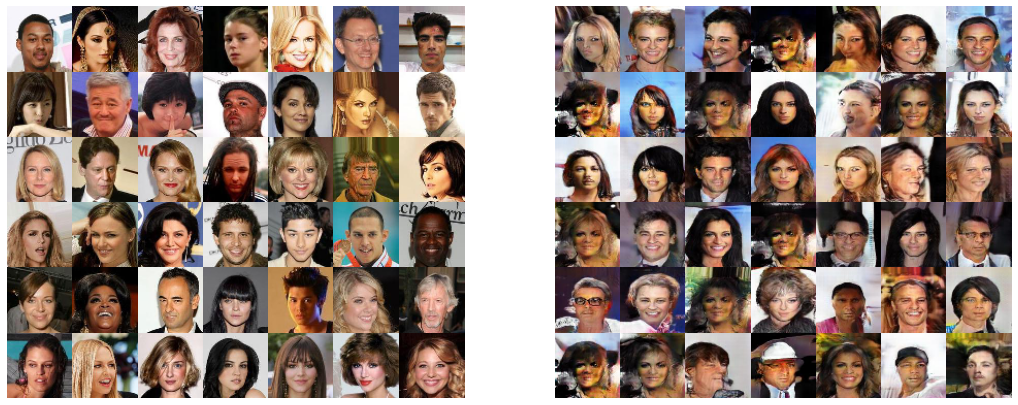

In [ ]:
# display cropped CelebA images and DCGAN images side by side
# left hand side: cropped CelebA images; right hand side: DCGAN images
fig = plt.figure(figsize=(18, 18))
real_img_grid = ImageGrid(fig, 121,
                          nrows_ncols=(6, 7),
                          axes_pad=0)

fake_img_grid = ImageGrid(fig, 122,  # similar to subplot(111)
                          nrows_ncols=(6, 7),  # creates 2x2 grid of axes
                          axes_pad=0,  # pad between axes in inch.
                          )

for ax, img_path in zip(real_img_grid, real_images):
    img = image.load_img(img_path, target_size=(64, 64))
    img = image.img_to_array(img)
    img /= 255
    # Iterating over the grid returns the Axes.
    ax.imshow(img)
    ax.axis("off")

for ax, img_path in zip(fake_img_grid, fake_images):
    img = image.load_img(img_path, target_size=(64, 64))
    img = image.img_to_array(img)
    img /= 255
    # Iterating over the grid returns the Axes.
    ax.imshow(img)
    ax.axis("off")

plt.show()

Left: Cropped, actual CelebA images

Right: Fake images generated by [2]

## **Deepfake Detector**
In our reference paper [1], the researchers targetted on 2 different CNN architectures: VGG-16 and ResNet-18. We want to test out various perturbation techniques against another architecture: *XceptionNet*.

Our training dataset is small (800 real images and 800 fake images), hence, we trained our detector model using *transfer learning* technique. The code used to create the XceptionNet deepfake detector can be found [here](https://colab.research.google.com/drive/141WZWsVz6fxynB0sgVmmAl8u33Pq0hiU?usp=sharing). We imported the weight file of our detector into this Colab.


In [ ]:
# download model
!gdown https://drive.google.com/uc?id=1UtDvRIVRWUvCMVZLDGIJk707-DGJ1lW1

Downloading...
From: https://drive.google.com/uc?id=1UtDvRIVRWUvCMVZLDGIJk707-DGJ1lW1
To: /content/model_fine_final.h5
276MB [00:03, 89.6MB/s]


In [ ]:
# load model
model_path = "/content/model_fine_final.h5"
final_model = load_model(model_path)

### **Model Performance Analysis**
We evaluate the performance of our XceptionNet deepfake detector on 400 images (200 real images and 200 fake images) which the model has never seen before.

Two main performance metrics which we are interested in are:
- Overall accuracy of the model: The ability of model to classify both real and fake images correctly
- Fake image detection accuracy: The ability of model to classify fake images as fake

In [ ]:
tp, fp, tn, fn = evaluate_model_performance(all_images, labels)
print("Total images used: %d" % len(all_images))
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)

Total images used: 400
Predict fake as fake: 185
Predict fake as real: 15
Predict real as real: 199
Predict real as fake: 1


Model Performance Summary:
- Total images used for testing: 400 (200 fake, 200 real)

Confusion matrix:

Actual/Pred | Fake | Real
---      |---   |---
Fake     | 185   | 15
Real     |  1   | 199


Overall Model Accuracy:
$\frac{185+199}{400}\times 100\% = 0.96 \times 100\% = 96\%$

Fake Image Detection Accuracy:
$\frac{185}{200}\times 100\% = 0.925 \times 100\% = 92.5\%$

Our XceptionNet deepfake detector is able to detect majority of fake faces.

## **Adversarial Attack**
From this point onwards, we will start attacking the deepfake detector!

Our aim is to create adversarial images which looks indifferent from the original images but can fool the deepfake detector.

### **Fast Gradient Sign Method (FGSM) Attack**
FGSM is an untargeted, white-box attack introduced in [3]. 

Given an input image, this method uses the sign of the gradients of  loss with respect to the input image to perturb the original image such that loss is maximised.

The formula to find adversarial example is as follows:
$$ X^{adv} = X + \epsilon sign(\nabla_X J(X, Y_{true}))$$
Here, <br>
X = original (clean) input <br>
$ X_{adv}$ = adversarial input (intentionally designed to be misclassified by our model) <br>
$ \epsilon $ = epsilon, the magnitude of adversarial perturbation  <br>
$ \nabla_X J(X, Y_{true}) $ = gradient of loss function w.r.t to input (X)

In [ ]:
# generate adversarial image using FGSM technique
def fgsm(img_path, input_label, eps=0.01):
    x = load_image_as_tensor(img_path)
    label = tf.one_hot(input_label, num_classes)
    label = tf.reshape(label, (1, num_classes))

    with tf.GradientTape() as tape:
      tape.watch(x)
      prediction = final_model(x)
      loss = categorical_crossentropy(label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, x)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)

    # perturb the original image with the grdient sign
    adv_x = x + eps*signed_grad

    # convert to numpy
    adv_x = adv_x.numpy()

    return adv_x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


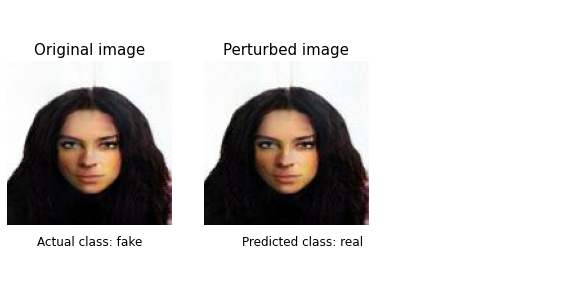

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


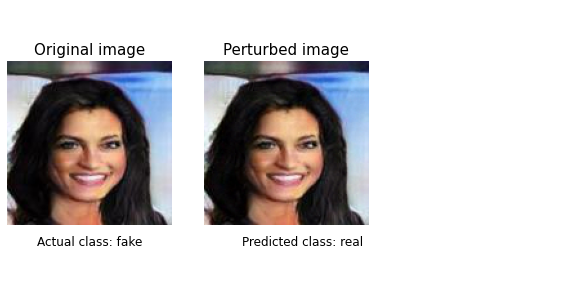

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


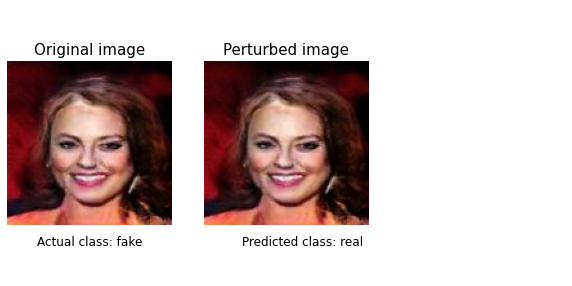

In [ ]:
tp, fp, tn, fn = evaluate_model_performance(all_images, labels, attack_fn="fgsm")

In [ ]:
print("Total images used: %d" % len(all_images))
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)

Total images used: 400
Predict fake as fake: 20
Predict fake as real: 180
Predict real as real: 184
Predict real as fake: 16


Model Performance Summary (after FGSM attack):
- Total images used for testing: 400 (200 fake, 200 real)

Confusion matrix:

Actual/Pred | Fake | Real
---      |---   |---
Fake     | 20   | 180
Real     |  16   | 184


Overall Model Accuracy:
$\frac{20+184}{400}\times 100\% = 0.51 \times 100\% = 51\%$

Fake Image Detection Accuracy:
$\frac{20}{200}\times 100\% = 0.10 \times 100\% = 10\%$


As shown above, the perturbed fake faces look the same as the origianl fake faces. However, the deepfake detector classifies the perturbed fake faces as real.

### **Fast Gradient Value Method (FGVM) Attack**
FGVM is very similar to FGSM, it is also an untargetted, white-box attack. 

It uses the raw gradient value instead of the gradient sign of gradient (as of in FGSM) when generating the adversarial image. FGVM usually generates more focused perturbations that cause less structural damage, i.e. the area being perturbed is usually smaller than FGSM.

The formula to find adversarial example is as follows:
$$ X^{adv} = X + \nabla_X J(X, Y_{true})$$
Here, <br>
X = original (clean) input <br>
$ X_{adv}$ = adversarial input (intentionally designed to be misclassified by our model) <br>
$ \nabla_X J(X, Y_{true}) $ = gradient of loss function w.r.t to input (X)


In [ ]:
# generate adversarial image using FGVM technique
def fgvm(img_path, input_label):
    x = load_image_as_tensor(img_path)
    label = tf.one_hot(input_label, num_classes)
    label = tf.reshape(label, (1, num_classes))

    with tf.GradientTape() as tape:
      tape.watch(x)
      prediction = final_model(x)
      loss = categorical_crossentropy(label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, x)

    adv_x = x + gradient

    # convert to numpy
    adv_x = adv_x.numpy()

    return adv_x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


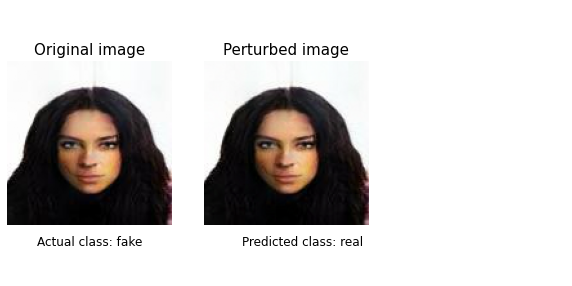

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


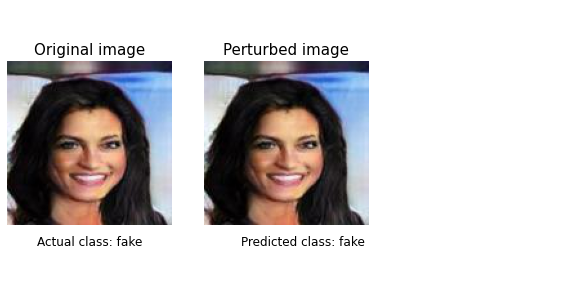

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


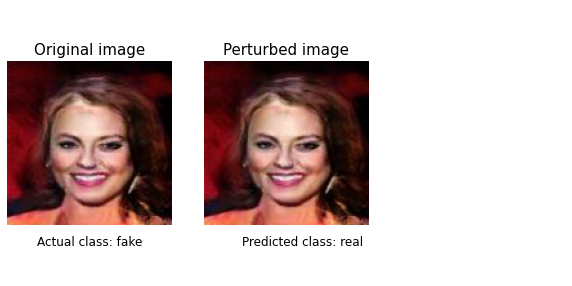

In [ ]:
tp, fp, tn, fn = evaluate_model_performance(all_images, labels, attack_fn="fgvm")

In [ ]:
print("Total images used: %d" % len(all_images))
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)

Total images used: 400
Predict fake as fake: 139
Predict fake as real: 61
Predict real as real: 197
Predict real as fake: 3


Model Performance Summary (after FGVM attack):
- Total images used for testing: 400 (200 fake, 200 real)

Confusion matrix:

Actual/Pred | Fake | Real
---      |---   |---
Fake     | 139   | 61
Real     |  3   | 197

Overall Model Accuracy: $\frac{139+197}{400}\times 100\% = 0.84 \times 100\% = 84\%$

Fake Image Detection Accuracy: $\frac{139}{200}\times 100\% = 0.695 \times 100\% = 69.5\%$



Again, we see that the perturbed images look the same as the images before perturbation. The detector classifies these perturbed fake images as real. However, the accuracy of detector does not drop as much as when it is attacked using FGSM.

### **One Pixel Attack**
One Pixel Attack is a method proposed by [4] that generates adversarial examples by *only modifying one pixel* of an image. We explore two variations of One Pixel Attack in this section. 

The first one is a naive attack where we change a random pixel to become yellow and investigate if it fools the detector.

The second attempt involves a more advanced algorithm called *differential evolution*. Given the probability value of each classes, this algorithm is able to select the most confident pixel. We then modify this pixel to become a certain colour, which leads the detector to see the fake image as real.

The code below mainly refers to the [official One Pixel Attack implementation](https://github.com/Hyperparticle/one-pixel-attack-keras).

In [ ]:
# Clone the relevant Github
!git clone https://github.com/Hyperparticle/one-pixel-attack-keras.git

Cloning into 'one-pixel-attack-keras'...
remote: Enumerating objects: 346, done.
remote: Total 346 (delta 0), reused 0 (delta 0), pack-reused 346
Receiving objects: 100% (346/346), 44.43 MiB | 35.13 MiB/s, done.
Resolving deltas: 100% (201/201), done.


In [ ]:
%cd /content/one-pixel-attack-keras

/content/one-pixel-attack-keras


In [ ]:
# import useful functions from the git
from differential_evolution import differential_evolution
import helper

#### **Change a single pixel to yellow**
A simple attempt of One-pixel attack which involves changing the centre pixel of an image to a colour (in this case, yellow).

In [ ]:
# change the centre pixel to yellow
pixel= np.array([64, 64, 255, 255, 0])
def simple_one_pixel_attack(x):
    attack_image = helper.perturb_image(pixel, x)
    return attack_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


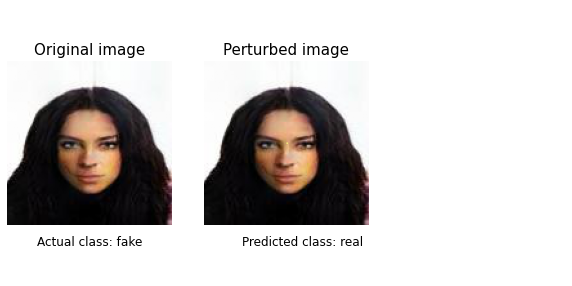

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


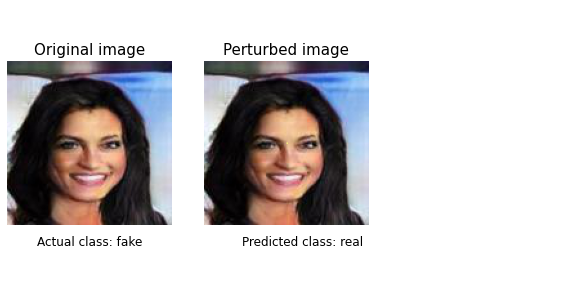

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


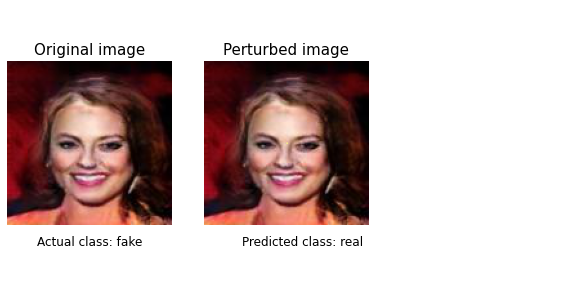

In [ ]:
tp, fp, tn, fn = evaluate_model_performance(all_images, labels, attack_fn="simple one pixel")

In [ ]:
print("Total images used: %d" % len(all_images))
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)

Total images used: 400
Predict fake as fake: 0
Predict fake as real: 200
Predict real as real: 200
Predict real as fake: 0


Model Performance Summary (after a Simple One Pixel attack):
- Total images used for testing: 400 (200 fake, 200 real)

Confusion matrix:

Actual/Pred | Fake | Real
---      |---   |---
Fake     | 0   | 200
Real     | 0    | 100

Overall Model Accuracy: $\frac{0+200}{400}\times 100\% = 0.5 \times 100\% = 50\%$

Fake Image Detection Accuracy: $\frac{0}{200}\times 100\% = 0 \times 100\% = 0\%$

You can see that the centre pixel of image has become yellow. This change will go unnotice if we do not observe intently. Even though it is a small perturbation, the deepfake detector cannot detect any fake faces anymore!

However, the detector is still able to recognise all the real faces.

#### **With differential evolution**
[Differential evolution](https://en.wikipedia.org/wiki/Differential_evolution#:~:text=In%20evolutionary%20computation%2C%20differential%20evolution,a%20given%20measure%20of%20quality.) is a population-based optimization technique which iteratively attempt to find a better candidate solution with regard to a given measure of quality. At each iteration of differential evolution, children will be produced based on the current population (parents). The children will only survive only if it fits better than their parents.

In this context, differential evolution is used to find *the most important pixel* in the image. If we perturb this pixel, it can minimise the confidence of detector to classify the image as its true label.


At the beginning, we have an array of 400 perturbations, where each perturbation is a tuple of (x, y, R, G, B). Each perturbation represents a candidate "most important pixel". At each iteration, 400 more perturbations (children) will be generated. If the child can minimise the classifier confidence more, then the child is said to have defeated its parent and survive. This population selection process continues until the iteration number hits 75 or the probability of target label has exceeded 90%.

Note: This attack takes about 40 minutes to run (with GPU).

In [ ]:
# auxiliary function used in differential evolution

# the objective function to be MINIMIZED in differential evolution
# we always want to minimize the probability of classifying the img into its original class
def predict_classes(pixels, img, actual_label, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    img_perturbed = helper.perturb_image(pixels, img)
    predictions = model.predict(img_perturbed)[:, actual_label]

    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

def attack_success(pixel, img, actual_label, model, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = helper.perturb_image(pixel, img)

    confidence = model.predict(attack_image)[0]
    predicted_label = np.argmax(confidence)

    if verbose:
        print('Confidence:', confidence[target_class])
    if predicted_label != actual_label:
        return True

In [ ]:
# find the most important pixel and perturb it
def one_pixel_attack(img, img_label, model, pixel_count=1, maxiter=75, popsize=400, verbose=False, plot=False):
      # Define bounds for x,y,r,g,b values
      dim_x, dim_y = 128, 128
      bounds = [(0, dim_x), (0, dim_y), (0, 256), (0, 256), (0, 256)] * pixel_count

      # Population multiplier, in terms of the size of the perturbation vector x
      popmul = max(1, popsize // len(bounds))

      # Format the predict/callback functions for the differential evolution algorithm
      def predict_fn(pixels):
          return predict_classes(pixels, img, img_label, model)

      def callback_fn(pixel, convergence):
          return attack_success(pixel, img, img_label, model, verbose)

      # Call Scipy's Implementation of Differential Evolution
      attack_result = differential_evolution(
          predict_fn, bounds, maxiter=maxiter, callback=callback_fn, popsize=popmul,recombination=0.7, atol=-1, polish=False)
      
      # attack_result.x contains the details of the pixel that we will use to perturb original image
      attack_image = helper.perturb_image(attack_result.x, img)

      return attack_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


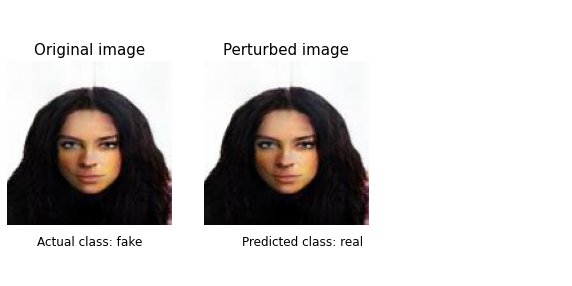

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


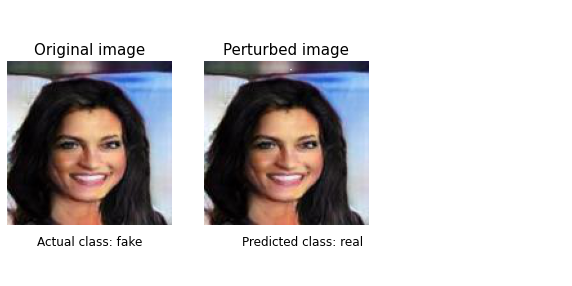

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


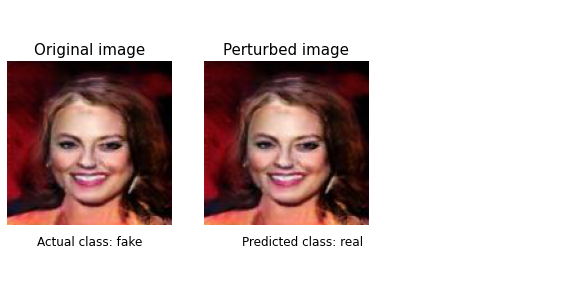

In [ ]:
tp, fp, tn, fn = evaluate_model_performance(all_images, labels, attack_fn="one pixel with differetial evolution")

In [ ]:
print("Total images used: %d" % len(all_images))
print("Predict fake as fake: %d" %tp)
print("Predict fake as real: %d" %fp)
print("Predict real as real: %d" %tn)
print("Predict real as fake: %d" %fn)

Total images used: 400
Predict fake as fake: 0
Predict fake as real: 200
Predict real as real: 84
Predict real as fake: 116


Model Performance Summary (after One Pixel attack):
- Total images used for testing: 400 (200 fake, 200 real)

Confusion matrix:

Actual/Pred | Fake | Real
---      |---   |---
Fake     | 0   | 200
Real     | 116    | 84

Overall Model Accuracy: $\frac{0+84}{400}\times 100\% = 0.21 \times 100\% = 21\%$

Fake Image Detection Accuracy: $\frac{0}{200}\times 100\% = 0 \times 100\% = 0\%$

Although not obvious, in the third example, you can see a yellow pixel around the lip corner of the face. This shows that in this One Pixel Attack variation, the pixel being perturbed is no longer fixed as the centre pixel.

Besides, we also see that this approach is a more powerful attack than the naive One Pixel Attack because the deepfake detector can no longer distinguish between real & fake faces!

## **Attack using Steganography Technique**

Steganography is a technique used to hide the existence of a thing. In the security context, it is a technique used to hide secret message within an image, audio or even a file. In this context, we attempt to hide a fake image within a real image and see if this is able to fool the deepfake detector.

Example of Steganography: </br>
![Steganography Example](https://mgitecetech.files.wordpress.com/2010/12/picture2.jpg)<br/>
*Image source: https://mgitecetech.files.wordpress.com/2010/12/picture2.jpg*<br/>


In our attempt, we try out Least Significant Bit Steganography (LSBSteg). We store the fake image RGB data in *the last two least significant bits (LSB)* of each pixel in the real image. 


The code below is mainly based on [this GitHub](https://github.com/ragibson/Steganography).


In [ ]:
%cd /content/

/content


In [ ]:
# create a directory to store all steganography images
!mkdir steganography

### **Steganography Functions**
This section contains functions that hide fake image data (secret) into the LSBs of real image (cover).

In [ ]:
# bit manipulation functions
byte_depth_to_dtype = {1: np.uint8, 2: np.uint16, 4: np.uint32, 8: np.uint64}

def roundup(x, base=1):
    return int(ceil(x / base)) * base

def lsb_interleave_bytes(carrier, payload, num_lsb, truncate=False, byte_depth=1):
    plen = len(payload)
    payload_bits = np.zeros(shape=(plen, 8), dtype=np.uint8)
    payload_bits[:plen, :] = np.unpackbits(
        np.frombuffer(payload, dtype=np.uint8, count=plen)).reshape(plen, 8)

    bit_height = roundup(plen * 8 / num_lsb)
    payload_bits.resize(bit_height * num_lsb)

    carrier_dtype = byte_depth_to_dtype[byte_depth]
    carrier_bits = np.unpackbits(
        np.frombuffer(carrier, dtype=carrier_dtype, count=bit_height).view(np.uint8)).reshape(bit_height, 8 * byte_depth)

    carrier_bits[:, 8 * byte_depth - num_lsb: 8 * byte_depth] = payload_bits.reshape(bit_height, num_lsb)

    ret = np.packbits(carrier_bits).tobytes()
    return ret if truncate else ret + carrier[byte_depth * bit_height:]

def lsb_deinterleave_bytes(carrier, num_bits, num_lsb, byte_depth=1):
    plen = roundup(num_bits / num_lsb)
    carrier_dtype = byte_depth_to_dtype[byte_depth]
    payload_bits = np.unpackbits(
        np.frombuffer(carrier, dtype=carrier_dtype, count=plen).view(np.uint8)
    ).reshape(plen, 8 * byte_depth)[:, 8 * byte_depth - num_lsb: 8 * byte_depth]
    return np.packbits(payload_bits).tobytes()[: num_bits // 8]

def lsb_interleave_list(carrier, payload, num_lsb):
    bit_height = roundup(8 * len(payload) / num_lsb)
    carrier_bytes = np.array(carrier[:bit_height], dtype=np.uint8).tobytes()
    interleaved = lsb_interleave_bytes(carrier_bytes, payload, num_lsb, truncate=True)
    carrier[:bit_height] = np.frombuffer(interleaved, dtype=np.uint8).tolist()
    return carrier

def lsb_deinterleave_list(carrier, num_bits, num_lsb):
    plen = roundup(num_bits / num_lsb)
    carrier_bytes = np.array(carrier[:plen], dtype=np.uint8).tobytes()
    deinterleaved = lsb_deinterleave_bytes(carrier_bytes, num_bits, num_lsb)
    return deinterleaved

In [ ]:
# we set the number of LSBs used to hide data as 2
num_lsb = 2

# AUXILIARY METHODS #
def _str_to_bytes(x, charset=sys.getdefaultencoding(), errors="strict"):
    if x is None:
        return None
    if isinstance(x, (bytes, bytearray, memoryview)):  # noqa
        return bytes(x)
    if isinstance(x, str):
        return x.encode(charset, errors)
    if isinstance(x, int):
        return str(x).encode(charset, errors)
    raise TypeError("Expected bytes")

def get_filesize(path):
    """Returns the file size in bytes of the file at path"""
    return os.stat(path).st_size

def max_bits_to_hide(image):
    """Returns the number of bits we're able to hide in the cover image using
    num_lsb least significant bits."""
    # 3 color channels per pixel, num_lsb bits per color channel.
    return int(3 * image.size[0] * image.size[1] * num_lsb)

def bytes_in_max_file_size(image):
    """Returns the number of bits needed to store the size of the file."""
    return roundup(max_bits_to_hide(image).bit_length() / 8)

In [ ]:
# ENCODING/HIDING #
def prepare_hide(cover_image_path, secret_image_path):
    """Prepare files for reading and writing for hiding data."""
    cover = Image.open(cover_image_path)
    secret = open(secret_image_path, "rb")
    return cover, secret

def hide_message_in_image(cover_image, message):
    # in some cases the image might already be opened
    if isinstance(cover_image, Image.Image):
        image = cover_image
    else:
        image = Image.open(cover_image)

    num_channels = len(image.getdata()[0])
    flattened_color_data = [v for t in image.getdata() for v in t]

    # We add the size of the input file to the beginning of the payload
    message_size = len(message)
    file_size_tag = message_size.to_bytes(bytes_in_max_file_size(image), byteorder=sys.byteorder)
    data = file_size_tag + _str_to_bytes(message)

    # start to hide data (payload) into cover_image
    if 8 * len(data) > max_bits_to_hide(image):
        raise ValueError(
            f"Only able to hide {max_bits_to_hide(image) // 8} bytes "
            + f"in this image with {num_lsb} LSBs, but {len(data)} bytes were requested"
        )

    flattened_color_data = lsb_interleave_list(flattened_color_data, data, num_lsb)

    # PIL expects a sequence of tuples, one per pixel
    image.putdata(list(zip(*[iter(flattened_color_data)] * num_channels)))
    return image

def encode_image(cover_image_path, secret_image_path):
    """Hides the secret image in the cover image."""
    cover, secret = prepare_hide(cover_image_path, secret_image_path)
    cover = hide_message_in_image(cover, secret.read())
    secret.close()
    # cover now contains the secret
    cover_arr = np.array(cover) # change cover into a np array
    return cover, cover_arr

### **Create steganography images**
In this implementation, the cover image (real face) and secret (fake face) must be of the same size.

In [ ]:
# display cover, secret and steganography outputs in a row
def display_deep_steganography(cover_path, secret_path, steg_path, pred_label):
    cover_img = load_image_as_np_arr(cover_path).squeeze()
    cover_img = denormalize_img(cover_img)

    secret_img = load_image_as_np_arr(secret_path).squeeze()
    secret_img = denormalize_img(secret_img)

    steg_img = load_image_as_np_arr(steg_path).squeeze()
    steg_img = denormalize_img(steg_img)

    # both x and adv_x are numpy array
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(cover_img); ax[0].axis("off")
    ax[0].set_title("Cover image", fontsize=15)
    
    ax[1].imshow(secret_img); ax[1].axis("off")
    ax[1].set_title("Secret image", fontsize=15)
    
    ax[2].imshow(steg_img); ax[2].axis("off")
    ax[2].set_title("Encoded image", fontsize=15)
    ax[2].text(2.95,-0.13, "Predicted class: {}".format(classes[pred_label]), 
                size=12, ha="center", transform=ax[0].transAxes)
    
    plt.show()

In [ ]:
# function that evaluate steganography technique
# classify fake images after hiding fake img behind real img
# (after attack, expected to be classified as real, i.e. label 0)
def evaluate_steganography(real_imgs, fake_imgs, display_num=3):
    pred_as_real = 0
    pred_as_fake = 0
    output_num = 0
    # for now, we aim to fool the detector by hiding fake image behind real image
    actual_label = 1
    # steganography images (PNG file paths), to demonstrate that we can recover fake image from the encoded image
    steg_png_paths = []

    for i in range(len(fake_imgs)):
        real_img = real_imgs[i] # filepath of the real (cover) image
        fake_img = fake_imgs[i] # filepath of the fake (secret) image

        # create steganography image (advesarial fake image)
        steg_output, steg_output_arr = encode_image(real_img, fake_img)
        adv_x = np.expand_dims(steg_output_arr, axis=0)

        # predict the encoded image
        pred_label = classify(final_model, adv_x)

        # selectively display a few fake images result
        display_imgs = ["111.jpg", "251.jpg", "698.jpg"]
        if os.path.basename(fake_img) in display_imgs:
            # write the steganography image as a png file
            fake_filename = os.path.basename(fake_img)
            fake_filename = os.path.splitext(fake_filename)[0]
            steg_img = "/content/steganography/steg_{}.png".format(fake_filename)
            steg_output.save(steg_img, compress_level = 1)
            steg_png_paths.append(steg_img)

            # display real, fake and steganography images
            display_deep_steganography(real_img, fake_img, steg_img, pred_label)

        # compare prediction with ground truth
        # label 0: real, label 1: fake
        if pred_label == 0:
            pred_as_real += 1
        else:
            pred_as_fake += 1
        output_num += 1

    return pred_as_real, pred_as_fake, output_num, steg_png_paths

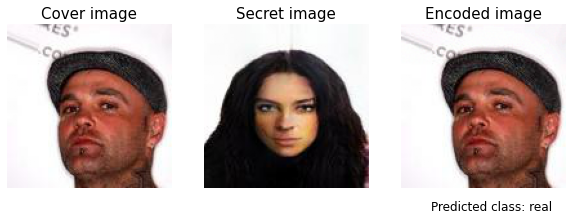

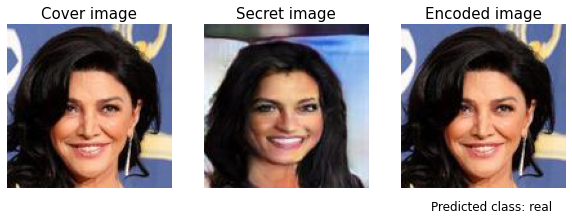

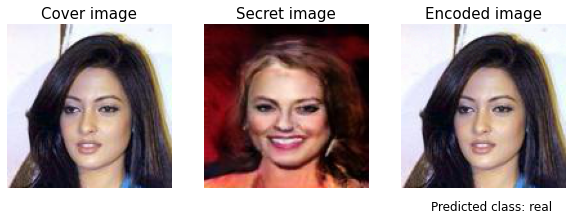

In [ ]:
# separate the real and fake images so that we can know the cover image and fake image
real_img_paths = glob.glob("/content/testing_images/real/*")
fake_img_paths = glob.glob("/content/testing_images/fake/*")
pred_as_real, pred_as_fake, output_num, steg_imgs = evaluate_steganography(real_img_paths, fake_img_paths)

In [ ]:
print("Total number of images encoded: %d" %output_num)
print("Number of images predicted as real by model: %d" %pred_as_real)
print("Number of images predicted as fake by model: %d" %pred_as_fake)

Total number of images encoded: 200
Number of images predicted as real by model: 200
Number of images predicted as fake by model: 0


Model Performance Summary (using Steganography Technique):
- Total number of encoded images = 200


Fake Image Detection Accuracy: $\frac{0}{200}\times 100\% = 0 \times 100\% = 0\%$

As shown in the outputs above, there is no traces of the fake images that are being hidden within the real images. The fake images "disappear" from our view as well as "escape" from the detection of the deepfake detector.

All fake images are predicted as real by the model.

### **Recover fake images**
We have shown that steganography technique is able to fool the detector. However, the attack becomes meaningless if we lost our fake images in the process. Fear not, in this section, we show that we can easily recover the fake image by recreating it from the LSB values in the steganography image.



In [ ]:
# DECODING/RECOVERING #
def prepare_recover(steg_image_path, output_file_path):
    """Prepare files for reading and writing for recovering data."""
    steg_image = Image.open(steg_image_path)
    output_file = open(output_file_path, "wb+")
    return steg_image, output_file

def recover_message_from_image(input_image):
    """Returns the message from the steganographed image"""
    if isinstance(input_image, Image.Image):
        steg_image = input_image
    else:
        steg_image = Image.open(input_image)

    color_data = [v for t in steg_image.getdata() for v in t]

    # retrieve the size of secret image
    file_size_tag_size = bytes_in_max_file_size(steg_image)
    tag_bit_height = roundup(8 * file_size_tag_size / num_lsb)

    bytes_to_recover = int.from_bytes(
        lsb_deinterleave_list(
            color_data[:tag_bit_height], 8 * file_size_tag_size, num_lsb
        ),
        byteorder=sys.byteorder,
    )

    maximum_bytes_in_image = (max_bits_to_hide(steg_image) // 8 - file_size_tag_size)
    if bytes_to_recover > maximum_bytes_in_image:
        raise ValueError(
            "This image appears to be corrupted.\n"
            + f"It claims to hold {bytes_to_recover} B, "
            + f"but can only hold {maximum_bytes_in_image} B with {num_lsb} LSBs"
        )

    # recovering data
    data = lsb_deinterleave_list(color_data, 8 * (bytes_to_recover + file_size_tag_size), num_lsb)[file_size_tag_size:]
    return data

def decode_image(steg_image_path, output_file_path):
    """Writes the data from the steganographed image to the output file"""
    steg_image, output_file = prepare_recover(steg_image_path, output_file_path)
    data = recover_message_from_image(steg_image)
    output_file.write(data)
    output_file.close()

In [ ]:
def show_recovered_img(steg_img_name):
    recovered_img_path = "/content/steganography/recover_{}".format(steg_img_name)

    # determine the file path of the original fake image
    fake_img_name = os.path.splitext(steg_img_name)[0]

    steg_img_path = "/content/steganography/steg_{}.png".format(fake_img_name)
    # recover image and write the recovered image into the given path
    decode_image(steg_img_path, recovered_img_path)

    secret_img_path = "/content/testing_images/fake/" + fake_img_name + ".jpg"

    # show encoded image, original fake image and recovered image side by side
    encoded = load_image_as_np_arr(steg_img_path).squeeze()
    encoded = denormalize_img(encoded)

    secret = load_image_as_np_arr(secret_img_path).squeeze()
    secret = denormalize_img(secret)

    recovered = load_image_as_np_arr(recovered_img_path).squeeze()
    recovered = denormalize_img(recovered)

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(encoded); ax[0].axis("off")
    ax[0].set_title("Encoded image", fontsize=15)
    
    ax[1].imshow(secret); ax[1].axis("off")
    ax[1].set_title("Secret image", fontsize=15)
    
    ax[2].imshow(recovered); ax[2].axis("off")
    ax[2].set_title("Recovered image", fontsize=15)
    
    plt.show()


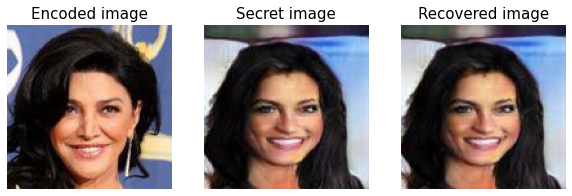

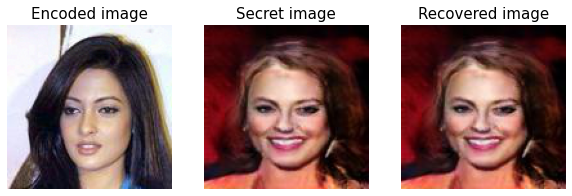

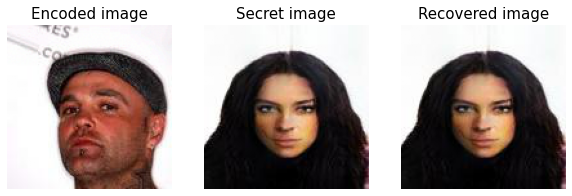

In [ ]:
display_imgs = ["111.jpg", "251.jpg", "698.jpg"]

for steg_img_name in display_imgs:
    show_recovered_img(steg_img_name)

As shown above, all fake images are successfully recovered.

## **How do we defend against these attacks?**



### **Robust Deepfake Detector**

One way to mitigate attacks is to train and *use a detector that is robust to adversarial attacks*. For example, [2] proposed a deepfake detector that classifies images using power spectrum. The researchers noticed that at high frequency, the power spectrum of fake images is different from the spectrum of real images, as shown in the graph below.

![Power spectrum](https://github.com/cc-hpc-itwm/DeepFakeDetection/raw/master/imgs/1000_celeba.png)<br/>
*Image source: https://github.com/cc-hpc-itwm/DeepFakeDetection/raw/master/imgs/1000_celeba.png*<br/>

Coincidentally, [2] is also a main reference paper used by **Team Light.DP** and also the work which produced the 1000 fake images used in our assignment.

In [another Colab](https://colab.research.google.com/drive/1Cm1V4vNydHMilchqqxJjvkKv996FEEs4?usp=sharing), we remain on the Dark side and  attempt to fool this more advanced deepfake detector. The detector is a RBF kernel SVM classifier which classifies images based on their power spectrum. We tried two attacks on it: 
- Black-box Transfer-based FGSM
- Steganography


### **Create FGSM Perturbed Images for black-box transfer-based FGSM**

Based on [5], we learnt that adversarial techniques such as FGSM has transferability across different models. Since the FGSM perturbed images managed to fool our XceptionNet detector, we would like to know whether the same images can fool the above mentioned SVM classifier. This is considered as a black-box attack as the perturbed values were computed based on the gradient of loss of the XceptionNet and not the SVM classifier. 

Hence, in this section, we create and download 1000 perturbed fake images using FGSM.

In [ ]:
# perturbed images will be stored in this directory
!mkdir fgsm

In [ ]:
# download the 1000 DCGAN images generated by the researchers
!gdown https://drive.google.com/uc?id=15YcbdUTmyZQL6R4nZ4Bo2u0fy4tCpmdn

Downloading...
From: https://drive.google.com/uc?id=15YcbdUTmyZQL6R4nZ4Bo2u0fy4tCpmdn
To: /content/dataset_celebA.7z
3.06MB [00:00, 92.9MB/s]


In [ ]:
!p7zip -d /content/dataset_celebA.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 3056195 bytes (2985 KiB)

Extracting archive: /content/dataset_celebA.7z
--
Path = /content/dataset_celebA.7z
Type = 7z
Physical Size = 3056195
Headers Size = 7356
Method = LZMA2:22
Solid = +
Blocks = 1

  0%     68% 2 - dataset_celebA/.ipynb_checkpoints/0-checkpoint.jpg                                                            68% 951 - dataset_celebA/947.jpg                                 Everything is Ok

Folders: 2
Files: 1007
Size:       3678484
Compressed: 3056195


In [ ]:
normal_fake = glob.glob("/content/dataset_celebA/*")
len(normal_fake)

1000

In [ ]:
# perturb all 1000 images using FGSM technique
for img_path in normal_fake:
    adv_x = fgsm(img_path, 1)
    adv_x = adv_x.squeeze()
    adv_x = denormalize_img(adv_x)
    # need to rescale FGSM perturbed images to range [0..255]
    rescaled_adv_x = (255.0 / adv_x.max() * (adv_x - adv_x.min())).astype(np.uint8)

    # save perturbed image 
    img_name = os.path.basename(img_path)
    filename = "/content/fgsm/fgsm_{}".format(img_name) 
    im = Image.fromarray(rescaled_adv_x)
    im.save(filename)

In [ ]:
# zip perturbed images and download folder
!zip -q -r fgsm_output.zip "/content/fgsm"

In [ ]:
# download output zip file
from google.colab import files
files.download("/content/fgsm_output.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Both our attacks fail. This shows that **classifying images using power spectrum is a plausible method to overcome adversarial attacks**.

### **Image Pre-processing: Pixel Deflection**

Pixel deflection is a technique introduced in [6]. [6] claimed that CNN classifiers are generally robust to natural noises in real images. Hence, in this technique, we purposefully *add some noises to the adversarial images*, to force the image to match natural image statistics, i.e. force the image to fall into the distribution of its actual class. To add noises, we simply randomly replace some pixels with some other randomly selected pixels from a small neighbourhood, as shown in the functions below.


The code below mainly refers to the [official source code](https://github.com/iamaaditya/pixel-deflection).





In [ ]:
%matplotlib inline
from random import randint, uniform

In [ ]:
# Wavelet denoiser
from skimage.restoration import denoise_wavelet
def denoiser(img):
    # img is a np array with the shape: (H, W, C)
    return denoise_wavelet(img/255.0, sigma=0.0005, mode='soft', multichannel=True, convert2ycbcr=True, method='BayesShrink')*255.0

In [ ]:
def pixel_deflection(img, deflections=200, window=10):
    # img is a np array with the shape: (1, H, W, C)
    img = np.copy(img)
    img = img.squeeze()
    H, W, C = img.shape

    # deflections: number of pixels that will be deflected
    while deflections > 0:
        # for consistency, we deflect a pixel from all three channels
        for c in range(C):
            x,y = randint(0,H-1), randint(0,W-1)
            # this ensures the neighbourhood pixel lies within the image
            while True:
                a,b = randint(-1*window,window), randint(-1*window,window)
                if x+a < H and x+a > 0 and y+b < W and y+b > 0: break
            img[x,y,c] = img[x+a,y+b,c] 
        deflections -= 1

    # denoise the deflected image
    # we denoise the image because generally, both perturbations and deflections are noise, so we want to smooth the image
    img = denoiser(img)
    img = np.expand_dims(img, axis=0)
    # denoised deflected image also has the shape of (1, H, W, C)
    return img


To try out this defense technique, we **switch to the Light side** and attempt to defend the attacks launched by **Team Dark.Faceless Men**. Similar to us, Team Dark.Faceless Men had also tried to fool a deepfake detector. The attack techniques that they had tried out are:
- FGSM
- FGVM
- FGSM & FGVM with Knowledge Distillation

Our attempt to defend the first two attacks can be found in [Colab 1](https://colab.research.google.com/drive/1_fE2iOLfhDPhOhwGMNdMFLCjJzrBJpC_?usp=sharing). The defense against the last attack can be found in [Colab 2](https://colab.research.google.com/drive/16xnt6ZvYqt5UIJFHfbmRbA724Lb8hqdb?usp=sharing).

Our attempt in Colab 1 shows promising result. Hence, we know that **pixel deflection can defend the normal black-box FGSM and FGVM attacks**.

However, we find that pixel deflection **does not work against FGSM and FGVM with Knowledge Distillation**, as shown in Colab 2. In this Colab, the perturbation amount used by Team Dark.Faceless Men is quite high, and hence the images contain a lot of noise. After we apply pixel deflection, it further increases the amount of noise in the images.

We suspect that the noise added through pixel deflection has been treated as perturbation as well and hence the accuracy of the deepfake detector does not improve much.

## **Summary**
We have demonstrated 4 different attacks, namely **FGSM, FGVM, One Pixel Attack and Least Significant Bit Steganography**, which can fool our XceptionNet deepfake detector.

We have also attempted to attack Team Light.DP and Team Dark.Faceless Men. From these attacks, we learn that classifying images using their power spectrum helps to distinguish between adversarial fake images and real images. We have also learnt that pixel deflection is a defense technique that can be used to defend FGSM and FGVM attacks.

## **Strategies Used**
- adversarial gaming: flipping between sides
- minimizing revelations
- early exposure
- familiarity breeds attempts
- uniqueness by obscurity
- blindside resilience
- blind faith
- looking over your shoulder
- abstention
- indistinguishability obfuscation

**What strategies have I used?**
<br/>Team-based:
- topic choice: familiarity breeds attempt
- progress update timing: early exposure
- adversarial gaming: switch from dark to light

<br/> Individual-based:
- blindside resillience (volunteer to do coding, pay close attention to all the datasets and coding to make sure there is no trap)
- deception (deceive teammate)
- observing other teams (empty colab to minimize revelations, Team Dark.Faceless Men when migrating from Kaggle to Colab, changed the way they ported the dataset to achieve indistinguishability obfuscation)

**Any improvements I would like to make?**
- publish video to Youtube to attract more views/ likes/ shares
- pay more attention to other teams despite Light.DP and Dark.Faceless Men
- should think of ways to overcome the limited interactions in class, maybe can try collusion next time
- the quality of deepfakes we generated are not vey good, suspect its because of the CelebA dataset (medium resolution), hence we cannot generate high-resolution images. If given more time, would want to generate better deepfakes next time.

**How do increase creativity?**
- in terms of the attack technique maybe..?
- currently attacks are based on previous researchers' works that revolve around adversarial attacks
- haven't explored the transferability and effectiveness of methods that are not specifically for fooling detectors, e.g. some image pre-processing technique like image reconstruction
- video storyboard can be more creative? like in the form of two people dialogues, more interactive, instead of just presenting facts

**How to increase uniqueness?**
- my approach was to switch side
- the current topic clashes with Team Dark.Faceless Men, maybe next time can choose a topic that is different and unique
- but still want to make sure that everyone is familiar with the topic because familiarity breeds attempt

**Strategy that I am most proud of.**
- adversarial gameplay
- helps my team to stand out among all other teams
- increase the uniqueness and creativeness of the work
- research is more complete, can give more information to the public --> attack techniques is to spread awareness so that the public can be more careful of what they are seeing, defense techniques is to show the public that the academic have been working hard to tackle deepfakes problems too, hence they can be a little bit assured that their lives and social media will not be dominated by deepfakes




## **References**

[1] A. Gandhi and S. Jain, "Adversarial Perturbations Fool Deepfake Detectors," *2020 International Joint Conference on Neural Networks (IJCNN)*, Glasgow, United Kingdom, 2020, pp. 1-8, doi: 10.1109/IJCNN48605.2020.9207034.

[2] R. Durall, M. Keuper, F. J. Pfreundt and J. Keuper, "Unmasking deepfakes with simple features," *arXiv preprint*, 2019, arXiv:1911.00686.

[3] I. J. Goodfellow, J. Shlens and Szegedy, C, " Explaining and harnessing adversarial examples," *arXiv preprint*, 2014, arXiv:1412.6572.

[4] J. Su, D. V. Vargas and K. Sakurai, "One Pixel Attack for Fooling Deep Neural Networks," in *IEEE Transactions on Evolutionary Computation*, vol. 23, no. 5, pp. 828-841, Oct. 2019, doi: 10.1109/TEVC.2019.2890858.

[5] W. Zhou, X. Hou, Y. Chen, M. Tang, X. Huang, X. Gan and Y. Yang, "Transferable adversarial perturbations," in *Proceedings of the European Conference on Computer Vision (ECCV)*, pp. 452-467, 2018.

[6] A. Prakash, N. Moran, S. Garber, A. DiLillo and J. Storer, "Deflecting Adversarial Attacks with Pixel Deflection," *2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition*, Salt Lake City, UT, 2018, pp. 8571-8580, doi: 10.1109/CVPR.2018.00894.